In [ ]:
!pip install numpy pandas matplotlib

In [ ]:
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

uploaded = files.upload()

filename = next(iter(uploaded))
final_dataset = pd.read_csv(io.BytesIO(uploaded[filename]))

print("File loaded")

Saving dataset_motors_500.csv to dataset_motors_500.csv
File caricato con successo!


In [ ]:
motor_ids = final_dataset['motor_id'].unique()
total_motors = len(motor_ids)

In [ ]:
# Indexes for cutting the dataset (70% - 20% - 10%)
train_end = int(total_motors * 0.7)
val_end = int(total_motors * 0.9)

train_ids = motor_ids[:train_end]
val_ids = motor_ids[train_end:val_end]
test_ids = motor_ids[val_end:]

print(f"\n--- Splitting ---")
print(f"Motori Training: {len(train_ids)} (ID: {train_ids[0]}...{train_ids[-1]})")
print(f"Motori Validation: {len(val_ids)}")
print(f"Motori Test: {len(test_ids)}")


--- Splitting ---
Motori Training: 350 (ID: 1...350)
Motori Validation: 100
Motori Test: 50


In [ ]:
# Dataframe
train_df = final_dataset[final_dataset['motor_id'].isin(train_ids)].copy()
val_df = final_dataset[final_dataset['motor_id'].isin(val_ids)].copy()
test_df = final_dataset[final_dataset['motor_id'].isin(test_ids)].copy()

In [ ]:
# ==========================================
# 3. NORMALIZATION (MinMax Scaling)
# ==========================================
# Normalizing only feature (input) and not RUL (output)

In [ ]:
feature_cols = ['vibration', 'temperature', 'current']
target_col = 'RUL'

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# FIT only on Training Set to avoid Data Leakage
scaler.fit(train_df[feature_cols])

MinMaxScaler()

In [ ]:
# Transform
train_df[feature_cols] = scaler.transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("\n--- Normalizzazione Completata ---")
print("Esempio dati normalizzati (Prime 5 righe Training):")
print(train_df[feature_cols].head())


--- Normalizzazione Completata ---
Esempio dati normalizzati (Prime 5 righe Training):
   vibration  temperature   current
0   0.127953     0.062189  0.112626
1   0.094488     0.072139  0.083720
2   0.104331     0.050995  0.091901
3   0.107283     0.060945  0.103627
4   0.085630     0.048507  0.092719


In [ ]:
# ==========================================
# 4. WINDOWING (Sliding Window for LSTM)
# ==========================================

In [ ]:
def create_sequences(dataframe, seq_length, features, target):
    X = []
    y = []

    for motor_id in dataframe['motor_id'].unique():
        motor_data = dataframe[dataframe['motor_id'] == motor_id]

        data_x = motor_data[features].values
        data_y = motor_data[target].values

        # Windows
        # Se il motore ha vissuto 1000 cicli e seq_length è 50,
        # avremo 950 campioni da questo motore.
        num_samples = len(data_x) - seq_length

        for i in range(num_samples):
            X.append(data_x[i : i + seq_length]) # Input: from t to t+50
            y.append(data_y[i + seq_length])     # Target: RUL to t+50

    return np.array(X), np.array(y)

In [ ]:
SEQ_LENGTH = 50

In [ ]:
print(f"\n--- Creazione Sequenze (Window Size: {SEQ_LENGTH}) ---")
X_train, y_train = create_sequences(train_df, SEQ_LENGTH, feature_cols, target_col)
X_val, y_val = create_sequences(val_df, SEQ_LENGTH, feature_cols, target_col)
X_test, y_test = create_sequences(test_df, SEQ_LENGTH, feature_cols, target_col)


--- Creazione Sequenze (Window Size: 50) ---


In [ ]:
# ==========================================
# 5. FINAL VERIFY (Output Shapes)
# ==========================================

print(f"Training X shape: {X_train.shape} | y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape} | y shape: {y_val.shape}")
print(f"Test X shape:     {X_test.shape} | y shape: {y_test.shape}")

print("\nLegend Shape: (Sample number, Temporal Steps, Sensor Number)")


✅ Dati pronti per TensorFlow/Keras:
Training X shape: (479948, 50, 3) | y shape: (479948,)
Validation X shape: (137784, 50, 3) | y shape: (137784,)
Test X shape:     (69721, 50, 3) | y shape: (69721,)

Legenda Shape: (Numero Campioni, Passi Temporali, Numero Sensori)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# --- 1. Config ---
input_shape = (X_train.shape[1], X_train.shape[2])

print(f"Input Shape per la LSTM: {input_shape}")

Input Shape per la LSTM: (50, 3)


In [ ]:
# --- 2. Architecture ---
model = Sequential([
    # Layer di Input esplicito
    Input(shape=input_shape),

    # FIRST LAYER LSTM
    # units=64: Neurons(Memory)
    LSTM(units=64, return_sequences=True, activation='tanh'),

    # DROPOUT
    Dropout(0.2),

    # SECOND LAYER LSTM
    LSTM(units=32, return_sequences=False, activation='tanh'),

    Dropout(0.2),

    # LAYER DENSE
    Dense(units=16, activation='relu'),

    # OUTPUT LAYER
    # units=1: Prediction of only one number
    # activation='linear': (Default) Regression task
    Dense(units=1)
])

In [ ]:
# --- 3. COMPILING ---
# Optimizer 'adam': Standard
# Loss 'mse': Mean Squared Error
# Metrics 'mae': Mean Absolute Error
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 4. CALLBACKS ---
callbacks = [
    # EarlyStopping: Stop Training if  'val_loss' not improve in 5 epochs.
    # Overfitting Problem
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    ModelCheckpoint('best_rul_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
# --- 5. TRAINING ---
print("\nAvvio addestramento...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nAddestramento completato!")


Avvio addestramento...
Epoch 1/50
14999/14999 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 228629.3125 - mae: 339.4770
Epoch 1: val_loss improved from inf to 50727.82422, saving model to best_rul_model.keras
14999/14999 ━━━━━━━━━━━━━━━━━━━━ 152s 10ms/step - loss: 228621.6719 - mae: 339.4698 - val_loss: 50727.8242 - val_mae: 158.7604
Epoch 2/50
14998/14999 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 60415.5273 - mae: 174.1899
Epoch 2: val_loss improved from 50727.82422 to 49004.58984, saving model to best_rul_model.keras
14999/14999 ━━━━━━━━━━━━━━━━━━━━ 146s 10ms/step - loss: 60415.3984 - mae: 174.1897 - val_loss: 49004.5898 - val_mae: 152.7569
Epoch 3/50
14998/14999 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 56470.7695 - mae: 164.9694
Epoch 3: val_loss improved from 49004.58984 to 47852.64453, saving model to best_rul_model.keras
14999/14999 ━━━━━━━━━━━━━━━━━━━━ 146s 10ms/step - loss: 56470.6875 - mae: 164.9692 - val_loss: 47852.6445 - val_mae: 146.4926
Epoch 4/50
14995/14999 ━━━━━━━━━━━━━━━━━

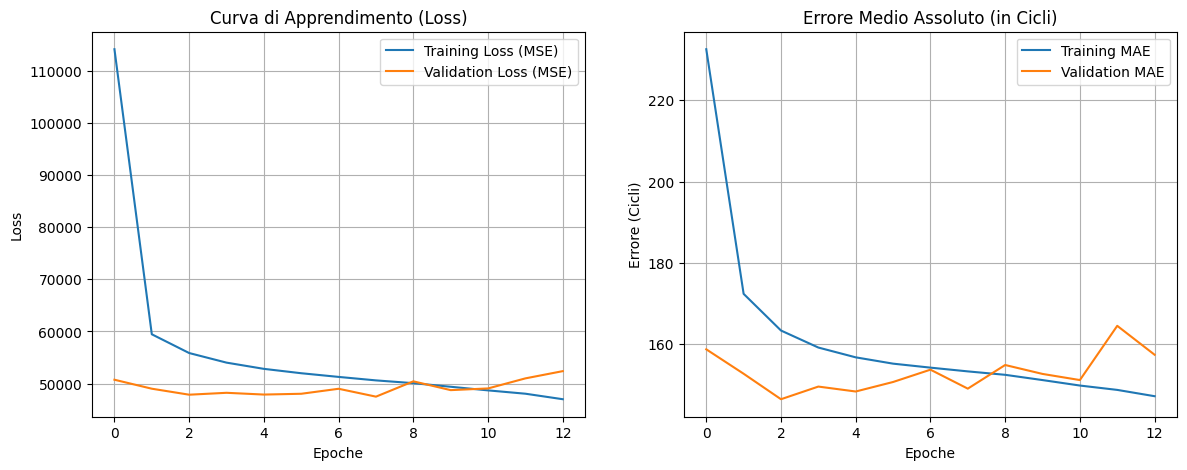


--- Valutazione Finale sul Test Set (Dati mai visti) ---
Errore Medio Assoluto (MAE) sul Test Set: 160.54 cicli
Se il ciclo è di 1 minuto, il modello sbaglia in media di 160.54 minuti.


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Graph 1: LOSS (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Curva di Apprendimento (Loss)')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Graph 2: MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Errore Medio Assoluto (in Cicli)')
    plt.xlabel('Epoche')
    plt.ylabel('Errore (Cicli)')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_history(history)

# --- TEST SET EVALUATION ---
print("\n--- Valutazione Finale sul Test Set (Dati mai visti) ---")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Errore Medio Assoluto (MAE) sul Test Set: {test_mae:.2f} cicli")
print(f"Se il ciclo è di 1 minuto, il modello sbaglia in media di {test_mae:.2f} minuti.")

In [ ]:
print("--- TEST 1: Predizione Singola ---")

# Take a random sample from the Test Set (which is already processed and windowed)
random_idx = np.random.randint(0, len(X_test))
sample_input = X_test[random_idx] # Forma: (50, 3)
true_rul = y_test[random_idx]

# Warning: the LSTM expects a "batch" of data.
# Even if it's a single sample, we need to reshape it from (50, 3) to (1, 50, 3)
sample_input_reshaped = sample_input.reshape(1, 50, 3)

# Prediction
predicted_rul = model.predict(sample_input_reshaped, verbose=0)[0][0]

print(f"Campione Indice: {random_idx}")
print(f"RUL Reale:     {true_rul:.1f} cicli")
print(f"RUL Predetta:  {predicted_rul:.1f} cicli")
print(f"Errore:        {abs(true_rul - predicted_rul):.1f} cicli")
print("-" * 30)

--- TEST 1: Predizione Singola ---
Campione Indice: 1031
RUL Reale:     153.0 cicli
RUL Predetta:  159.2 cicli
Errore:        6.2 cicli
------------------------------



--- TEST 2: Simulazione Vita Motore ---
Analisi completa del Motore ID: 451


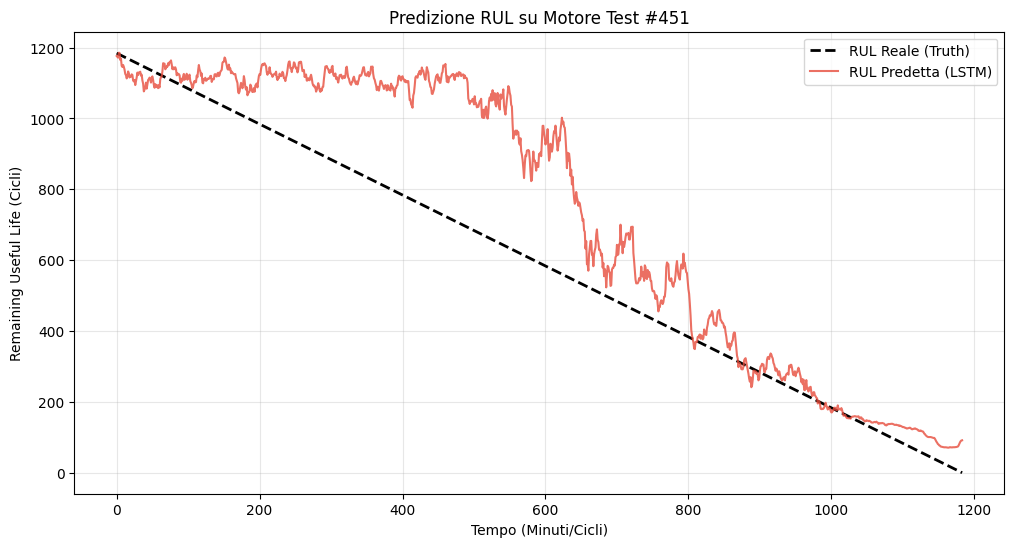

In [ ]:
# ==========================================
# TEST 2: Full Motor Life Simulation
# ==========================================
print("\n--- TEST 2: Simulazione Vita Motore ---")


# Choose the first motor in the test set for demonstration
test_motor_ids = test_df['motor_id'].unique()
chosen_motor_id = test_motor_ids[0]

print(f"Analisi completa del Motore ID: {chosen_motor_id}")

# Extract data for that motor
motor_data = test_df[test_df['motor_id'] == chosen_motor_id]

# Make sequences ONLY for this motor
# Using the same logic used for training
features = ['vibration', 'temperature', 'current']
data_values = motor_data[features].values
target_values = motor_data['RUL'].values

X_motor = []
y_motor = []
seq_length = 50

# Windowing
for i in range(len(data_values) - seq_length):
    X_motor.append(data_values[i : i + seq_length])
    y_motor.append(target_values[i + seq_length])

X_motor = np.array(X_motor)
y_motor = np.array(y_motor)

# 4. Make prediction on the FULL motor life at once
predictions = model.predict(X_motor, verbose=0)

# 5. Visualize the result
plt.figure(figsize=(12, 6))

# Real Line (Target) - It's a straight line going down
plt.plot(y_motor, label='RUL Reale (Truth)', color='black', linestyle='--', linewidth=2)

# Predicted Line (AI)
plt.plot(predictions, label='RUL Predetta (LSTM)', color='#e74c3c', alpha=0.8)

plt.title(f'Predizione RUL su Motore Test #{chosen_motor_id}')
plt.xlabel('Tempo (Minuti/Cicli)')
plt.ylabel('Remaining Useful Life (Cicli)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()